In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv("../src/data/raw_analyst_ratings/raw_analyst_ratings.csv")

In [19]:
print(df.shape)
df.head()


(1407328, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [20]:
# Add a column for headline length
df['headline_length'] = df['headline'].str.len()

# Calculate descriptive statistics for headline length
headline_stats = df['headline_length'].describe()

print("Headline Length Statistics:")
print(headline_stats)


Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [21]:
publisher_counts = df['publisher'].value_counts()

print("Number of Articles per Publisher:")
print(publisher_counts)

Number of Articles per Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


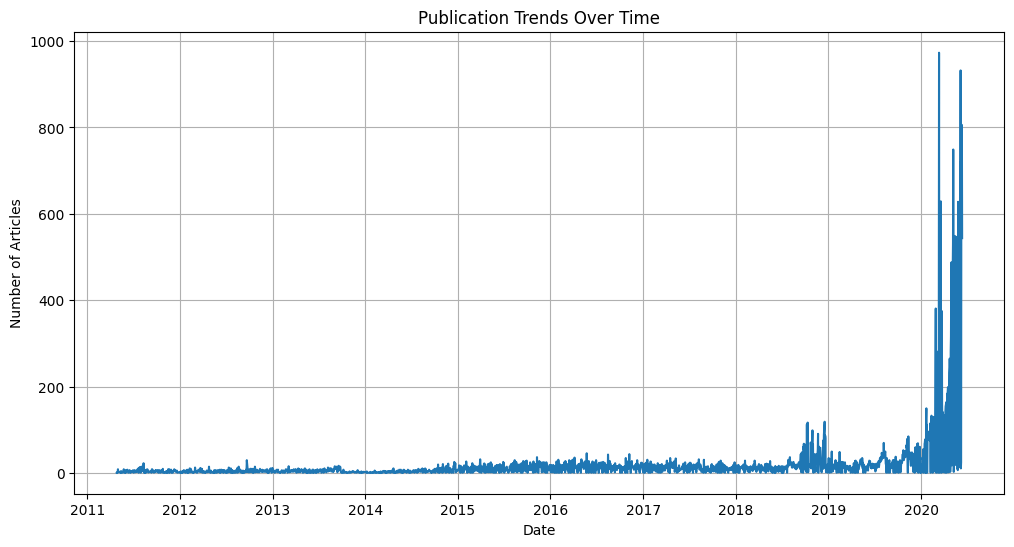

In [22]:
# Convert 'date' to datetime format
df = df.dropna(subset=['date'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract the date (without time)
df['publication_date'] = df['date'].dt.date

# Count articles by date
date_counts = df['publication_date'].value_counts().sort_index()

# print("Publication Trends Over Time:")
# print(date_counts)

# Plot the trends
plt.figure(figsize=(12, 6))
date_counts.plot(kind='line')
plt.title('Publication Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


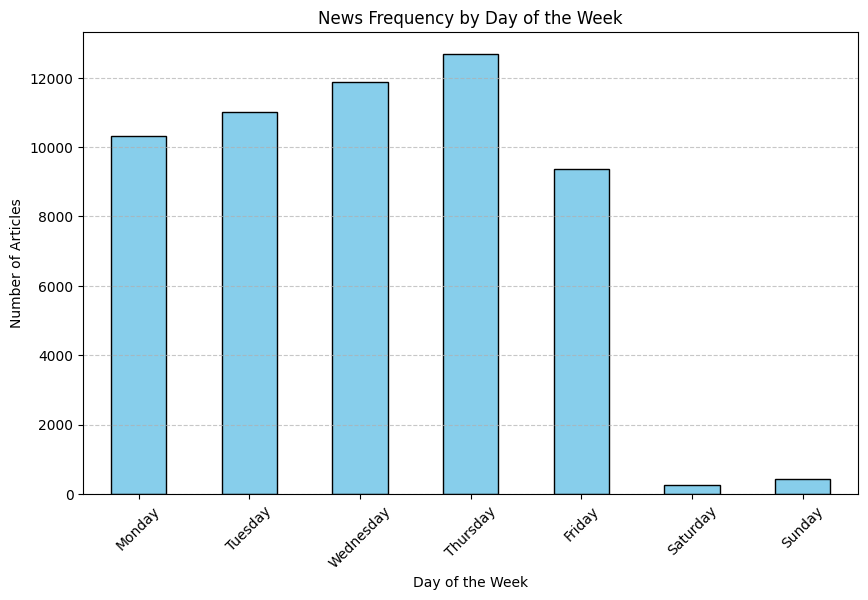

News Frequency by Day of the Week:
day_of_week
Monday       10322
Tuesday      11002
Wednesday    11891
Thursday     12688
Friday        9381
Saturday       267
Sunday         436
Name: count, dtype: int64


In [23]:
# Extract the day of the week
df['day_of_week'] = df['date'].dt.day_name()

day_counts = df['day_of_week'].value_counts()

# Sort the days to match the calendar order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order, fill_value=0)

# Plot the frequency of publications by day of the week
plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('News Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print days with the highest news frequency
print("News Frequency by Day of the Week:")
print(day_counts)

In [24]:
from textblob import TextBlob
df_sample = df.sample(10000)  # Work on a random sample of 10000 rows


# Apply sentiment analysis to the headlines
df_sample['sentiment_polarity'] = df_sample['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sample['sentiment_category'] = df_sample['sentiment_polarity'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)

# Display sentiment statistics
print(df_sample['sentiment_category'].value_counts())


sentiment_category
neutral     6714
positive    2426
negative     860
Name: count, dtype: int64


Preprocess the data

In [25]:
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing to the headlines
df_sample['cleaned_headline'] = df_sample['headline'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


perform sentiment analysis

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Calculate sentiment
df_sample['sentiment_score'] = df_sample['cleaned_headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_sample['sentiment_label'] = df_sample['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display sentiment statistics
print(df_sample['sentiment_label'].value_counts())


[nltk_data] Downloading package vader_lexicon to C:\Users\HP
[nltk_data]     EliteBook\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_label
neutral     5213
positive    3196
negative    1591
Name: count, dtype: int64


Identify common keywords

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Find common unigrams (single words) and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10)
common_words = vectorizer.fit_transform(df_sample['cleaned_headline'])
print(vectorizer.get_feature_names_out())


['earnings' 'eps' 'est' 'market' 'reports' 'sales' 'shares' 'stocks'
 'update' 'vs']


In [28]:
from sklearn.decomposition import LatentDirichletAllocation

# Convert text to a bag-of-words representation
vectorizer = CountVectorizer(max_features=500)
data_vectorized = vectorizer.fit_transform(df_sample['cleaned_headline'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(data_vectorized)
    
# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic 1:
['deal', 'top', 'new', 'dividend', 'industry', 'reports', 'stocks', 'morgan', 'announces', 'says']
Topic 2:
['premarket', 'moving', 'stocks', 'session', 'maintains', 'raises', 'reports', 'eps', 'est', 'vs']
Topic 3:
['us', 'scheduled', 'stock', 'companies', '52week', 'higher', 'trading', 'earnings', 'stocks', 'shares']
Topic 4:
['results', 'q4', 'q3', 'q1', 'hold', 'update', 'bank', 'estimate', 'eps', 'sales']
Topic 5:
['coverage', 'price', 'initiates', 'pt', 'update', 'upgrades', 'benzingas', 'downgrades', 'top', 'market']


Extract significant entities

In [ ]:
import spacy

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Extract named entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df_sample['entities'] = df_sample['headline'].apply(extract_entities)

# Filter for financial-related entities (e.g., ORG for organizations)
print(df_sample['entities'].head())


Time Series Analysis:

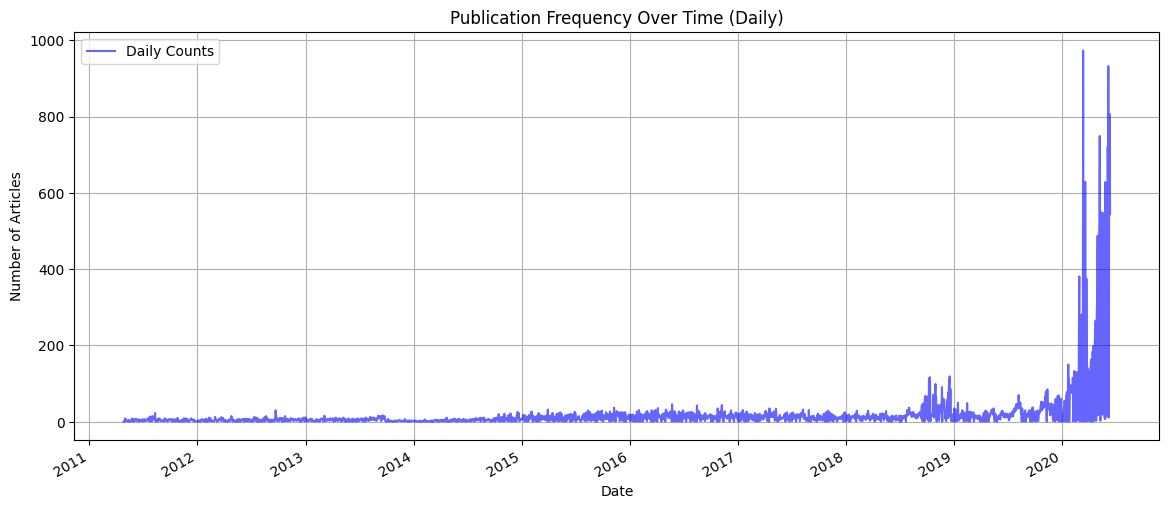

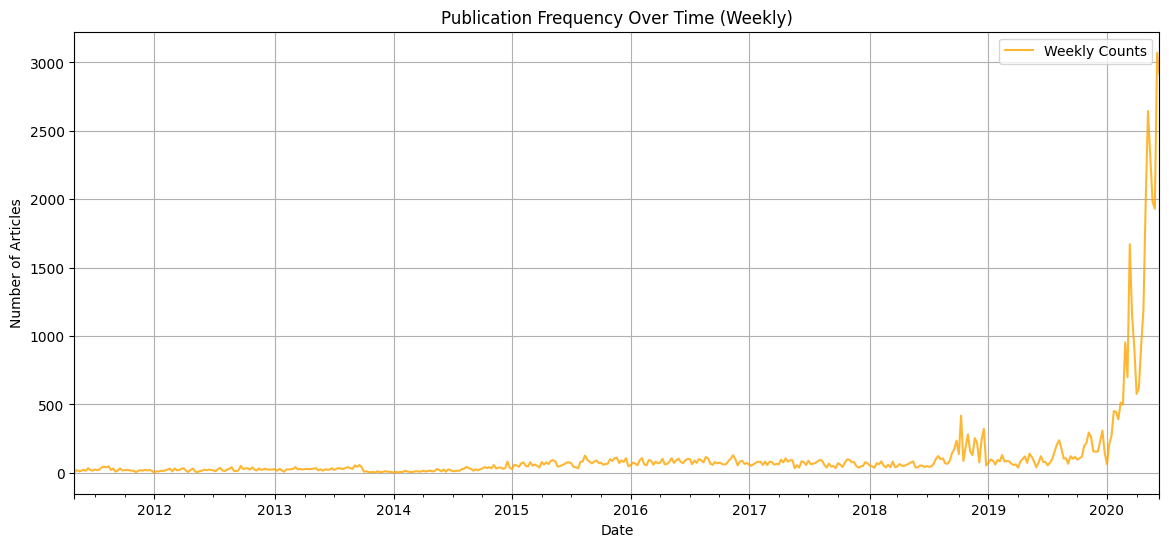

In [34]:
# Group by publication date and count articles
daily_counts = df.groupby('publication_date').size()

# Convert index to DatetimeIndex for resampling
daily_counts.index = pd.to_datetime(daily_counts.index)

# Resample to get weekly trends 
weekly_counts = daily_counts.resample('W').sum()

# Plot daily trends
plt.figure(figsize=(14, 6))
daily_counts.plot(kind='line', label='Daily Counts', color='blue', alpha=0.6)
plt.title('Publication Frequency Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.legend()
plt.show()

# Plot weekly trends for smoother view
plt.figure(figsize=(14, 6))
weekly_counts.plot(kind='line', label='Weekly Counts', color='orange', alpha=0.8)
plt.title('Publication Frequency Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.legend()
plt.show()
